In [1]:
%load_ext lab_black
%load_ext autotime

import drnb.embed.pipeline as pl

time: 7.92 s (started: 2023-03-10 23:08:34 -08:00)


Using a custom UMAP gradient coefficient. In this case, the squared loss between the affinities rather than cross entropy.

In [2]:
from dataclasses import dataclass
from typing import NamedTuple

from drnb.embed.umap.custom2 import custom_umap, CustomGradientUMAP2, epoch_func


def squmap_grad_coeff_attr(d2, grad_args):
    return -2.0 * pow(1.0 + d2, -2.0)


def squmap_grad_coeff_rep(d2, grad_args):
    return 2.0 * pow(1.0 + d2, -3.0)


class SQUMAP(CustomGradientUMAP2):
    def get_gradient_args(self):
        return None

    def __init__(self, **kwargs):
        if "anneal_lr" not in kwargs:
            kwargs["anneal_lr"] = True
        super().__init__(
            custom_epoch_func=epoch_func,
            custom_attr_func=squmap_grad_coeff_attr,
            custom_rep_func=squmap_grad_coeff_rep,
            **kwargs,
        )

time: 29.4 ms (started: 2023-03-10 23:08:59 -08:00)


[23:09:11] WARNING  151 nearest neighbors requested but only 150 items are available                  ]8;id=7251;file:///home/james/dev/drnb/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=287547;file:///home/james/dev/drnb/src/drnb/eval/nbrpres.py#56\56]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=519884;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=620660;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=714034;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=514670;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=664435;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=514101;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=339144;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=334859;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

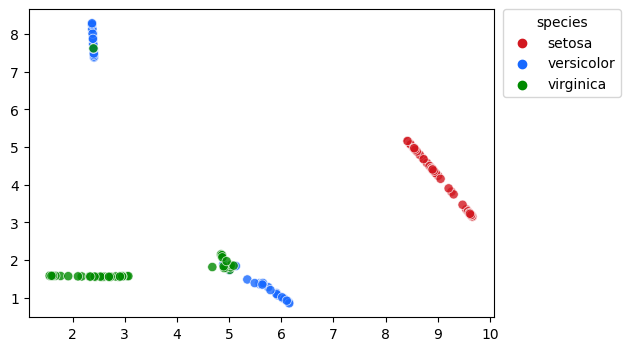

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7893333333333333, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6968587056201381, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7226666666666666, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8150666666666667, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=nan, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 7.42 s (started: 2023-03-10 23:09:07 -08:00)


In [3]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="iris",
)

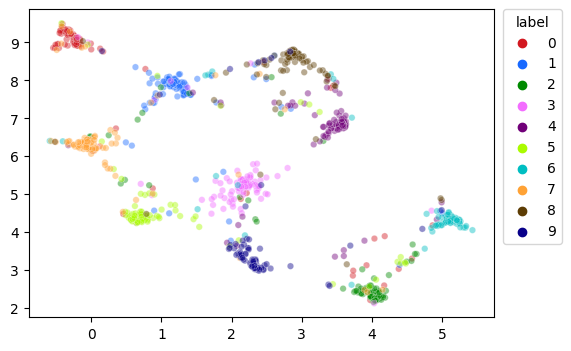

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5883999999999999, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2523687927952726, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.34106666666666674, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.45436, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.51034, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.56 s (started: 2023-03-10 23:10:49 -08:00)


In [6]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="s1k",
)

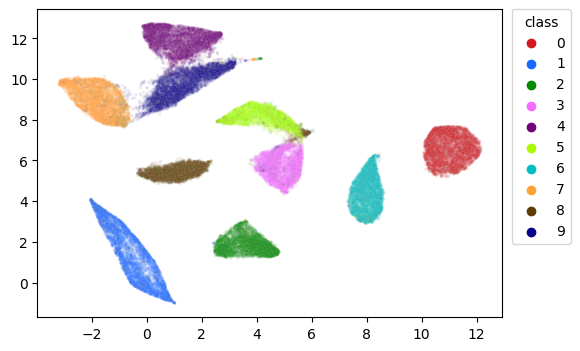

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6085542857142856, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3309336275519188, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.1069495238095238, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1704311428571429, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.25741161904761906, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 29.4 s (started: 2023-03-10 23:09:23 -08:00)


In [5]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="mnist",
)

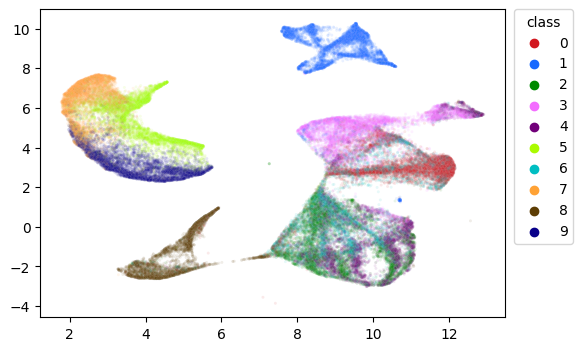

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7301942857142857, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.5967764323779879, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.11674285714285715, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.18499714285714286, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.273683619047619, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 30.5 s (started: 2023-03-10 23:11:03 -08:00)


In [7]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="fashion",
)